In [5]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from itertools import combinations, product
from sklearn import metrics, tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import RFE
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [2]:
# Read the raw data from the CSV file
raw_data = pd.read_csv('raw_data.csv')

# Copy the raw data before any modifications for the evaliation plot
data_with_years = raw_data[['Doc ID', 'Year']].copy()
data_with_years['Doc ID'] = data_with_years['Doc ID'].astype(str).str.zfill(7)

# Features that need to be normalized
features_to_normalize = [
    'Authors Mentions',
    'Concept Mentions (Total)',
    'Concept Mentions (Abstract)',
    'Concept Mentions (Number Of Paragraphs)',
    'Institute Mentions',
    'Age Of The Concept In Months',
    'Length of the Document',
    'Keyword 1 mentions', 
    'Keyword 2 mentions',
    'Keyword 3 mentions', 
    'Interpretative Word Count',
    "Number of Unique Words", "Number of Sentences", 
    "Average Sentence Length", "Exclamation Marks Count",
    "Question Marks Count", "Position of First Theory Mention", 
    "Number of Adjectives", "Number of Nouns",
    "Number of Verbs", "Number of Adverbs", "Lexical Density", "Flesch Reading Ease"
]

# Normalize these features
scaler = MinMaxScaler()
raw_data[features_to_normalize] = scaler.fit_transform(raw_data[features_to_normalize])

# Keep a copy of Doc IDs before dropping columns
doc_ids = raw_data['Doc ID'].copy()

# Remove the not necessary columns
drop_columns = ['Document Type', 'Contextual Phrase Count', 'Interpretative Word Count',
    "Number of Unique Words", "Number of Sentences", "Average Sentence Length", 
    "Exclamation Marks Count", "Question Marks Count", "Number of Adjectives", 
    "Number of Nouns", "Number of Verbs", "Number of Adverbs", 
    "Lexical Density", "Flesch Reading Ease"]
raw_data = raw_data.drop(drop_columns, axis=1)

In [3]:
f1_scores = []
recalls = []
precisions = []
accuracies = []

# Lists to store metrics for each class
f1_scores_classwise = {1: [], 2: [], 3: []}
recalls_classwise = {1: [], 2: [], 3: []}
precisions_classwise = {1: [], 2: [], 3: []}

for filename in glob.glob('doc_id_5_fold/*.csv'):
    with open(filename, 'r') as f:
        data = f.read().split("\n\n")
        train_ids = data[0].split("\n")
        test_ids = data[1].split("\n")  # Assuming that we only have training and test sets now.

        # Here raw_data should be defined somewhere above in your code
        raw_data['Doc ID'] = raw_data['Doc ID'].astype(str)
        raw_data['Doc ID'] = raw_data['Doc ID'].str.zfill(7)

        X_train = raw_data[raw_data['Doc ID'].isin(train_ids)].drop(['Doc ID', 'Career Stage'], axis=1)
        y_train = raw_data[raw_data['Doc ID'].isin(train_ids)]['Career Stage']

        X_test = raw_data[raw_data['Doc ID'].isin(test_ids)].drop(['Doc ID', 'Career Stage'], axis=1)
        y_test = raw_data[raw_data['Doc ID'].isin(test_ids)]['Career Stage']

        clf = DecisionTreeClassifier(random_state=42)  # Only specifying random_state for reproducibility
        clf.fit(X_train, y_train)
        test_preds = clf.predict(X_test)
        
        # Compute metrics for each class separately
        for class_label in [1, 2, 3]:
            f1_scores_classwise[class_label].append(f1_score(y_test, test_preds, labels=[class_label], average='weighted'))
            recalls_classwise[class_label].append(recall_score(y_test, test_preds, labels=[class_label], average='weighted'))
            precisions_classwise[class_label].append(precision_score(y_test, test_preds, labels=[class_label], average='weighted'))

        f1_scores.append(f1_score(y_test, test_preds, average='weighted'))
        recalls.append(recall_score(y_test, test_preds, average='weighted'))
        precisions.append(precision_score(y_test, test_preds, average='weighted'))
        accuracies.append(accuracy_score(y_test, test_preds))

# Output the results
print(f"F1 scores for each fold: {f1_scores}")
print(f"Recall for each fold: {recalls}")
print(f"Precision for each fold: {precisions}")
print(f"Accuracy for each fold: {accuracies}")

# Compute the average values
avg_f1 = sum(f1_scores) / len(f1_scores)
avg_recall = sum(recalls) / len(recalls)
avg_precision = sum(precisions) / len(precisions)
avg_accuracy = sum(accuracies) / len(accuracies)

# Print out the average values
print(f"\nAverage F1 score: {avg_f1:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print()

# Print out the metrics for each class
for class_label in [1, 2, 3]:
    print(f"\nMetrics for class {class_label}:")
    print(f"F1 scores: {f1_scores_classwise[class_label]}")
    print(f"Recall: {recalls_classwise[class_label]}")
    print(f"Precision: {precisions_classwise[class_label]}")
    print(f"Average F1 score: {sum(f1_scores_classwise[class_label]) / len(f1_scores_classwise[class_label]):.4f}")
    print(f"Average Recall: {sum(recalls_classwise[class_label]) / len(recalls_classwise[class_label]):.4f}")
    print(f"Average Precision: {sum(precisions_classwise[class_label]) / len(precisions_classwise[class_label]):.4f}")

F1 scores for each fold: [0.5924693155814437, 0.49684210526315786, 0.58, 0.506280193236715, 0.5599999999999999]
Recall for each fold: [0.631578947368421, 0.5263157894736842, 0.55, 0.5, 0.55]
Precision for each fold: [0.579630895420369, 0.47233468286099856, 0.6583333333333334, 0.5163636363636364, 0.625]
Accuracy for each fold: [0.631578947368421, 0.5263157894736842, 0.55, 0.5, 0.55]

Average F1 score: 0.5471
Average Recall: 0.5516
Average Precision: 0.5703
Average Accuracy: 0.5516


Metrics for class 1:
F1 scores: [0.6956521739130435, 0.7199999999999999, 0.7000000000000001, 0.6956521739130435, 0.6]
Recall: [0.6666666666666666, 0.75, 0.5833333333333334, 0.6666666666666666, 0.5]
Precision: [0.7272727272727272, 0.6923076923076922, 0.875, 0.7272727272727272, 0.75]
Average F1 score: 0.6823
Average Recall: 0.6333
Average Precision: 0.7544

Metrics for class 2:
F1 scores: [0.0, 0.0, 0.4, 0.0, 0.5]
Recall: [0.0, 0.0, 0.5, 0.0, 0.5]
Precision: [0.0, 0.0, 0.3333333333333333, 0.0, 0.5]
Average F1 

/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


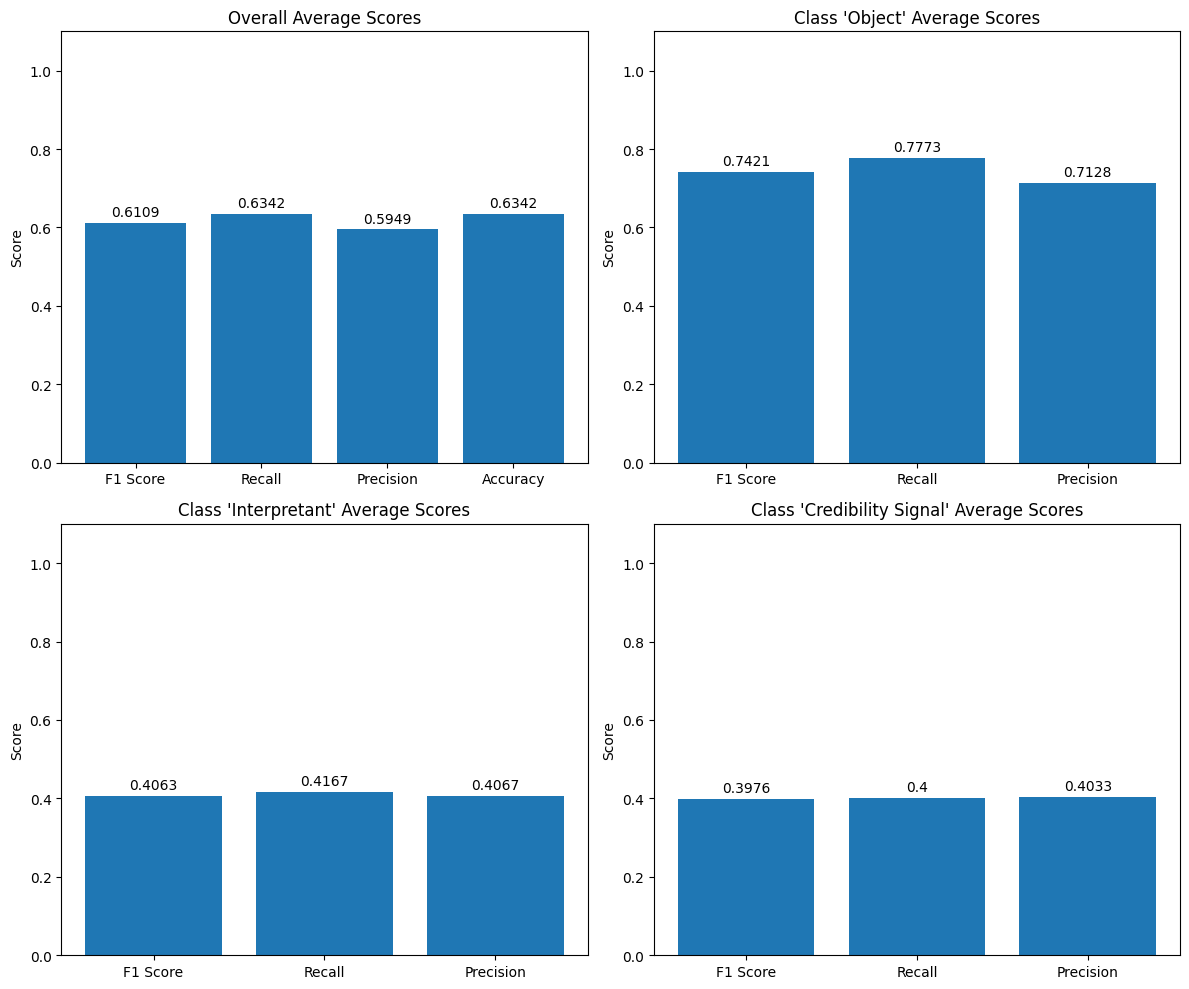

In [5]:
# Function to plot metrics with values
def plot_metrics(metrics, title, position, include_accuracy=True):
    plt.subplot(2, 2, position)
    
    labels = ['F1 Score', 'Recall', 'Precision']
    if include_accuracy:
        labels.append('Accuracy')
    
    bars = plt.bar(labels, metrics)
    plt.ylim(0, 1.1)  # Set y-axis limits between 0 and 1.1 for better visualization
    plt.title(title)
    plt.ylabel('Score')
    
    # Add values on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')

# Set the figure size
plt.figure(figsize=(12, 10))

# Plot overall average scores
overall_metrics = [avg_f1, avg_recall, avg_precision, avg_accuracy]
plot_metrics(overall_metrics, 'Overall Average Scores', 1)

# Dictionary to map class labels to their respective names
class_names = {
    1: '\'Object\'',
    2: '\'Interpretant\'',
    3: '\'Credibility Signal\''
}

# Plot metrics for each class
position = 2
for class_label, class_name in class_names.items():
    class_avg_f1 = sum(f1_scores_classwise[class_label]) / len(f1_scores_classwise[class_label])
    class_avg_recall = sum(recalls_classwise[class_label]) / len(recalls_classwise[class_label])
    class_avg_precision = sum(precisions_classwise[class_label]) / len(precisions_classwise[class_label])
    
    class_metrics = [class_avg_f1, class_avg_recall, class_avg_precision]
    
    plot_metrics(class_metrics, f'Class {class_name} Average Scores', position, include_accuracy=False)
    position += 1

plt.tight_layout()
plt.show()